# ResNet

## 前期设置

#### 导入需要用到的包

In [1]:
import os
import tarfile
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

#### 设置运算设备

若有可用的GPU设备，则设置变量device为'cuda'，否则为'cpu'。对之后代码中所有数据和模型参数使用.to(device)，就可以把它们转到我们想要的设备上。

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

#### 设置超参数

In [3]:
num_classes = 100  # 分类任务的类别数
batch_size = 32  # 每个小批次包含的样本数量
epochs = 5  # 训练周期数
lr = 1e-3  # 学习率

## 准备数据集

#### 导入数据集文件

若检测到未导入过数据集文件，则创建数据集存储路径，并将矩池云预置的数据集压缩文件解压至目标路径下。

In [4]:
if not os.path.exists('data/CIFAR-100'):  # 检测路径下是否已存在文件，若否，则执行以下代码
    os.mkdir('data/CIFAR-100')  # 创建数据存储路径，即data文件夹
    with tarfile.open('/public/keras_datasets/cifar-100-python.tar.gz') as tar:  # 矩池云上内置CIFAR-100数据集压缩文件的存储路径
        tar.extractall(path='data/CIFAR-100')  # 将数据集压缩文件解压，并保存至data文件夹中

#### 创建训练集、测试集

先使用torchvision.datasets中内置的CIFAR100类，将数据集文件转换为PyTorch中的数据集，并对其中的图片数据施加一定的预处理。接下来，使用DataLoader将数据集转化为分批次的数据读取器，可直接用于训练。

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 变形为ResNet所需的输入形状（224 * 224）
    transforms.ToTensor(),  # 转换为tensor（注意，此处的tensor默认在CPU上储存）
])

In [6]:
trainset = torchvision.datasets.CIFAR100(root='data/CIFAR-100', train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)  # 进行打乱

testset = torchvision.datasets.CIFAR100(root='data/CIFAR-100', train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)  # 不进行打乱

#### 展示数据集样例

trainloader的格式比较特殊，直接使用trainloader[0]取其中第一个元素会报错。我们先将其转换为Python中的迭代器类型，再用next函数取其中第一个元素。

In [7]:
images, labels = next(iter(trainloader))  # 获取训练集第一个批次中的图片及相应标签
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


查看训练集第一个批次中的图片。

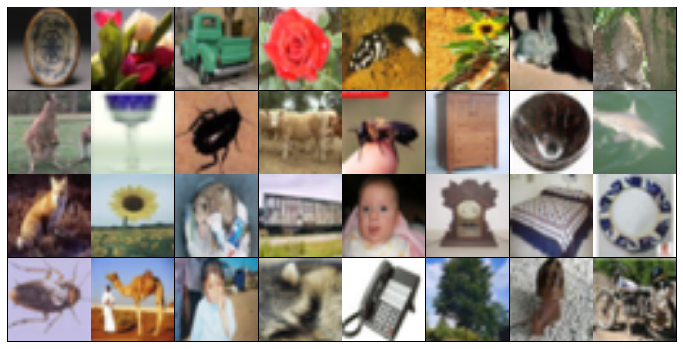

In [8]:
plt.figure(figsize=(12, 12))  # 设置画布大小
plt.axis('off')  # 隐藏坐标轴
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # make_grid函数把多张图片一起显示，permute函数调换channel维的顺序
plt.show()

## 构建模型

继承PyTorch内置的nn.Module类，即可构建任意自己想要的模型。模型中还可以嵌套模型。

首先构建ResNet残差模块，用于组成完整的ResNet-34网络。

<img src="https://tva1.sinaimg.cn/large/008eGmZEgy1gngkepcxekj30eg0bi0t8.jpg" style="zoom:50%">

一般残差模块的输入和输出形状相同，因此可以直接把输入作为short cut加入到最后的输出中。但有时，残差模块的第一个卷积层中需要进行下采样操作，使特征图的长宽减半、深度加倍。此时需要对输入进行特殊的1x1卷积，以改变其形状至与输出相同，使它们能够相加。

In [9]:
class ResNetModule(nn.Module):  # 继承nn.Module类
    
    def __init__(self, in_channels, downsample=False):
        super().__init__()  # 调用父类nn.Module的构造函数，为该类赋予一些特殊功能
        
        if downsample:  # 若该残差模块为下采样模块
            out_channels = 2 * in_channels  # 输出channel数设置为输入两倍
            stride = 2  # 第一个卷积层的stride设置为2，使特征图长宽减半
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),  # 用1x1卷积层来改变输入形状
                nn.BatchNorm2d(out_channels),
            )
        else:  # 若该残差模块为一般模块
            out_channels = in_channels  # 输出channel数设置为与输入相同
            stride = 1  # 第一个卷积层的stride设置为1，使特征图长宽不变
            self.downsample = None 
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):  # forward方法是一个特殊的方法，它会在model(input)的时候被调用
        if self.downsample is not None:  # 若该残差模块为下采样模块
            identity = self.downsample(x)  # 用1x1卷积层来改变输入形状
        else:
            identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)  # inplace=True使运算在原tensor上进行，不产生新的tensor，节省内存

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # 将（或许适当调整形状后的）原输入加到卷积层的输出中，ResNet的核心思想
        out = F.relu(out, inplace=True)

        return out

利用ResNet模块搭建ResNet-34网络。

<img src="https://tva1.sinaimg.cn/large/008eGmZEgy1gngkel9ssmj31fg0najwg.jpg" style="zoom:50%">

图中各块对应了代码中的conv1、conv2_x~conv5_x。

In [10]:
class ResNet34(nn.Module):  # 继承nn.Module类
    
    def __init__(self, num_classes):
        super().__init__()  # 调用父类nn.Module的构造函数，为该类赋予一些特殊功能
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        self.conv2_x = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            ResNetModule(64),
            ResNetModule(64),
            ResNetModule(64),
        )
        
        self.conv3_x = nn.Sequential(
            ResNetModule(64, downsample=True),  # 进行下采样
            ResNetModule(128),
            ResNetModule(128),
            ResNetModule(128),
        )
        
        self.conv4_x = nn.Sequential(
            ResNetModule(128, downsample=True),
            ResNetModule(256),
            ResNetModule(256),
            ResNetModule(256),
            ResNetModule(256),
            ResNetModule(256),
        )
        
        self.conv5_x = nn.Sequential(
            ResNetModule(256, downsample=True),
            ResNetModule(512),
            ResNetModule(512),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):  # forward方法是一个特殊的方法，它会在model(input)的时候被调用
        x = self.conv1(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [11]:
model = ResNet34(num_classes)
model.to(device)  # 将模型中所有参数tensor切换到GPU存储模式

model  # 展示模型的结构

ResNet34(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): ResNetModule(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResNetModule(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size

## 模型训练

先定义几个训练中会用到的函数。

In [12]:
# 计算模型预测准确率
def accuracy(outputs, labels):
    preds = torch.max(outputs, dim=1)[1]  # 获取预测类别
    return torch.sum(preds == labels).item() / len(preds)  # 计算准确率

In [13]:
# 模型验证
def validate(model, testloader):
    val_loss = 0
    val_acc = 0
    
    model.eval()  # 模型切换到预测模式
    
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
        outputs = model(inputs)  # 计算模型输出
        
        loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
        val_loss += loss.item()  # item方法提取出tensor中的数字
        
        acc = accuracy(outputs, labels)  # 计算准确率
        val_acc += acc
    
    model.train()  # 模型切换到训练模式
    
    val_loss /= len(testloader)  # 计算平均损失
    val_acc /= len(testloader)  # 计算平均准确率
    
    return val_loss, val_acc

In [14]:
# 打印训练结果
def print_log(epoch, train_time, train_loss, train_acc, val_loss, val_acc):
    print(f"Epoch [{epoch}/{epochs}], time: {train_time:.2f}s, loss: {train_loss:.4f}, acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

In [15]:
# 模型训练
def train(model, trainloader, testloader, epochs=1, lr=1e-3):
    model.train()  # 模型切换到训练模式
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # 设置优化器
    
    for epoch in range(1, epochs + 1):
        
        train_loss = 0
        train_acc = 0
        
        start = time.time()  # 记录本epoch开始时间
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式

            optimizer.zero_grad()  # 将模型所有参数tensor的梯度变为0（否则之后计算的梯度会与先前存在的梯度叠加）

            outputs = model(inputs)  # 计算模型输出

            loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
            train_loss += loss.item()  # item方法提取出tensor中的数字

            acc = accuracy(outputs, labels)  # 计算准确率
            train_acc += acc

            loss.backward()  # 调用PyTorch的autograd自动求导功能，计算loss相对于模型各参数的导数
            optimizer.step()  # 根据模型中各参数相对于loss的导数，以及指定的学习率，更新参数
        
        end = time.time()  # 记录本epoch结束时间
        train_time = end - start  # 计算本epoch的训练耗时
        
        train_loss /= len(trainloader)  # 计算平均损失
        train_acc /= len(trainloader)  # 计算平均准确率
        
        val_loss, val_acc = validate(model, testloader)  # 计算测试集上的损失函数和准确率
        
        print_log(epoch, train_time, train_loss, train_acc, val_loss, val_acc)  # 打印训练结果

输入参数epochs和lr，实施训练。

In [16]:
train(model, trainloader, testloader, epochs=epochs, lr=lr)  # 实施训练

Epoch [1/5], time: 137.33s, loss: 3.9716, acc: 0.0851, val_loss: 3.5061, val_acc: 0.1609
Epoch [2/5], time: 137.27s, loss: 3.2215, acc: 0.2046, val_loss: 2.8485, val_acc: 0.2827
Epoch [3/5], time: 137.35s, loss: 2.6061, acc: 0.3232, val_loss: 2.4834, val_acc: 0.3802
Epoch [4/5], time: 137.29s, loss: 2.1265, acc: 0.4271, val_loss: 2.7639, val_acc: 0.4619
Epoch [5/5], time: 137.28s, loss: 1.7564, acc: 0.5103, val_loss: 1.9167, val_acc: 0.4990


## 模型预测

从训练集中选取几张图片，使用模型做出预测，观察结果。

In [17]:
# 模型预测
def predict(model, inputs):
    model.eval()  # 模型切换到预测模式
    outputs = model(inputs.to(device))
    preds = torch.max(outputs, dim=1)[1]
    return preds

In [18]:
testiter = iter(testloader)

每次对迭代器testiter执行next，就会取出其下一个元素。因此，多次运行以下代码块，即可测试不同的图片。

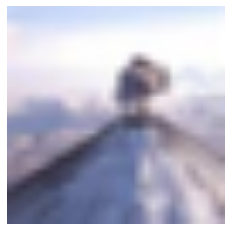

Prediction: train


In [19]:
image = next(testiter)[0][0]
plt.axis('off')
plt.imshow(image.permute((1, 2, 0)))
plt.show()

pred = predict(model, image.unsqueeze(dim=0))  # 由于模型接受的输入shape为4维（第1维为batch_size），因此需要使用unsqueeze函数在图片前面加一维
print('Prediction:', testset.classes[pred])